<a href="https://colab.research.google.com/github/Cralsic123/Optuna-for-abalone-dataset/blob/main/Optuna_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.8 MB/s eta 0:00:00


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor


In [3]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c playground-series-s4e4

  0% 0.00/2.41M [00:00<?, ?B/s]
100% 2.41M/2.41M [00:00<00:00, 139MB/s]


In [6]:
import zipfile
with zipfile.ZipFile('/content/playground-series-s4e4.zip', 'r') as zip_ref:
    zip_ref.extractall('./')



In [7]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/train.csv")

In [8]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [9]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [11]:
def transform_weight(df) :
    df['Weight_diff_1'] = df['Whole weight'] - df['Whole weight.1']
    df['Weight_diff_2'] = df['Whole weight'] - df['Whole weight.2'] - df['Shell weight']
    return df

train_df = transform_weight(train_df)
test_df = transform_weight(test_df)


In [12]:
pd.DataFrame(train_df.Rings.value_counts())

,count
Rings,
9,17465
8,14499
10,12464
7,9008
11,8407
6,5411
12,4719
13,4074
5,2862


In [13]:
numeric_cols = ['Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight',
       'Weight_diff_1', 'Weight_diff_2']
categorical_cols = ['Sex']
train_to_scale = train_df[numeric_cols]
test_to_scale = test_df[numeric_cols]

<ipython-input-14-a5b554824886>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=train_to_scale[col], ax=axs[i], inner="quartile", palette=[palette[i]])
<ipython-input-14-a5b554824886>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=train_to_scale[col], ax=axs[i], inner="quartile", palette=[palette[i]])
<ipython-input-14-a5b554824886>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=train_to_scale[col], ax=axs[i], inner="quartile", palette=[palette[i]])
<ipython-input-14-a5b554824886>:6: FutureWarning: 

Passing `palette` wit

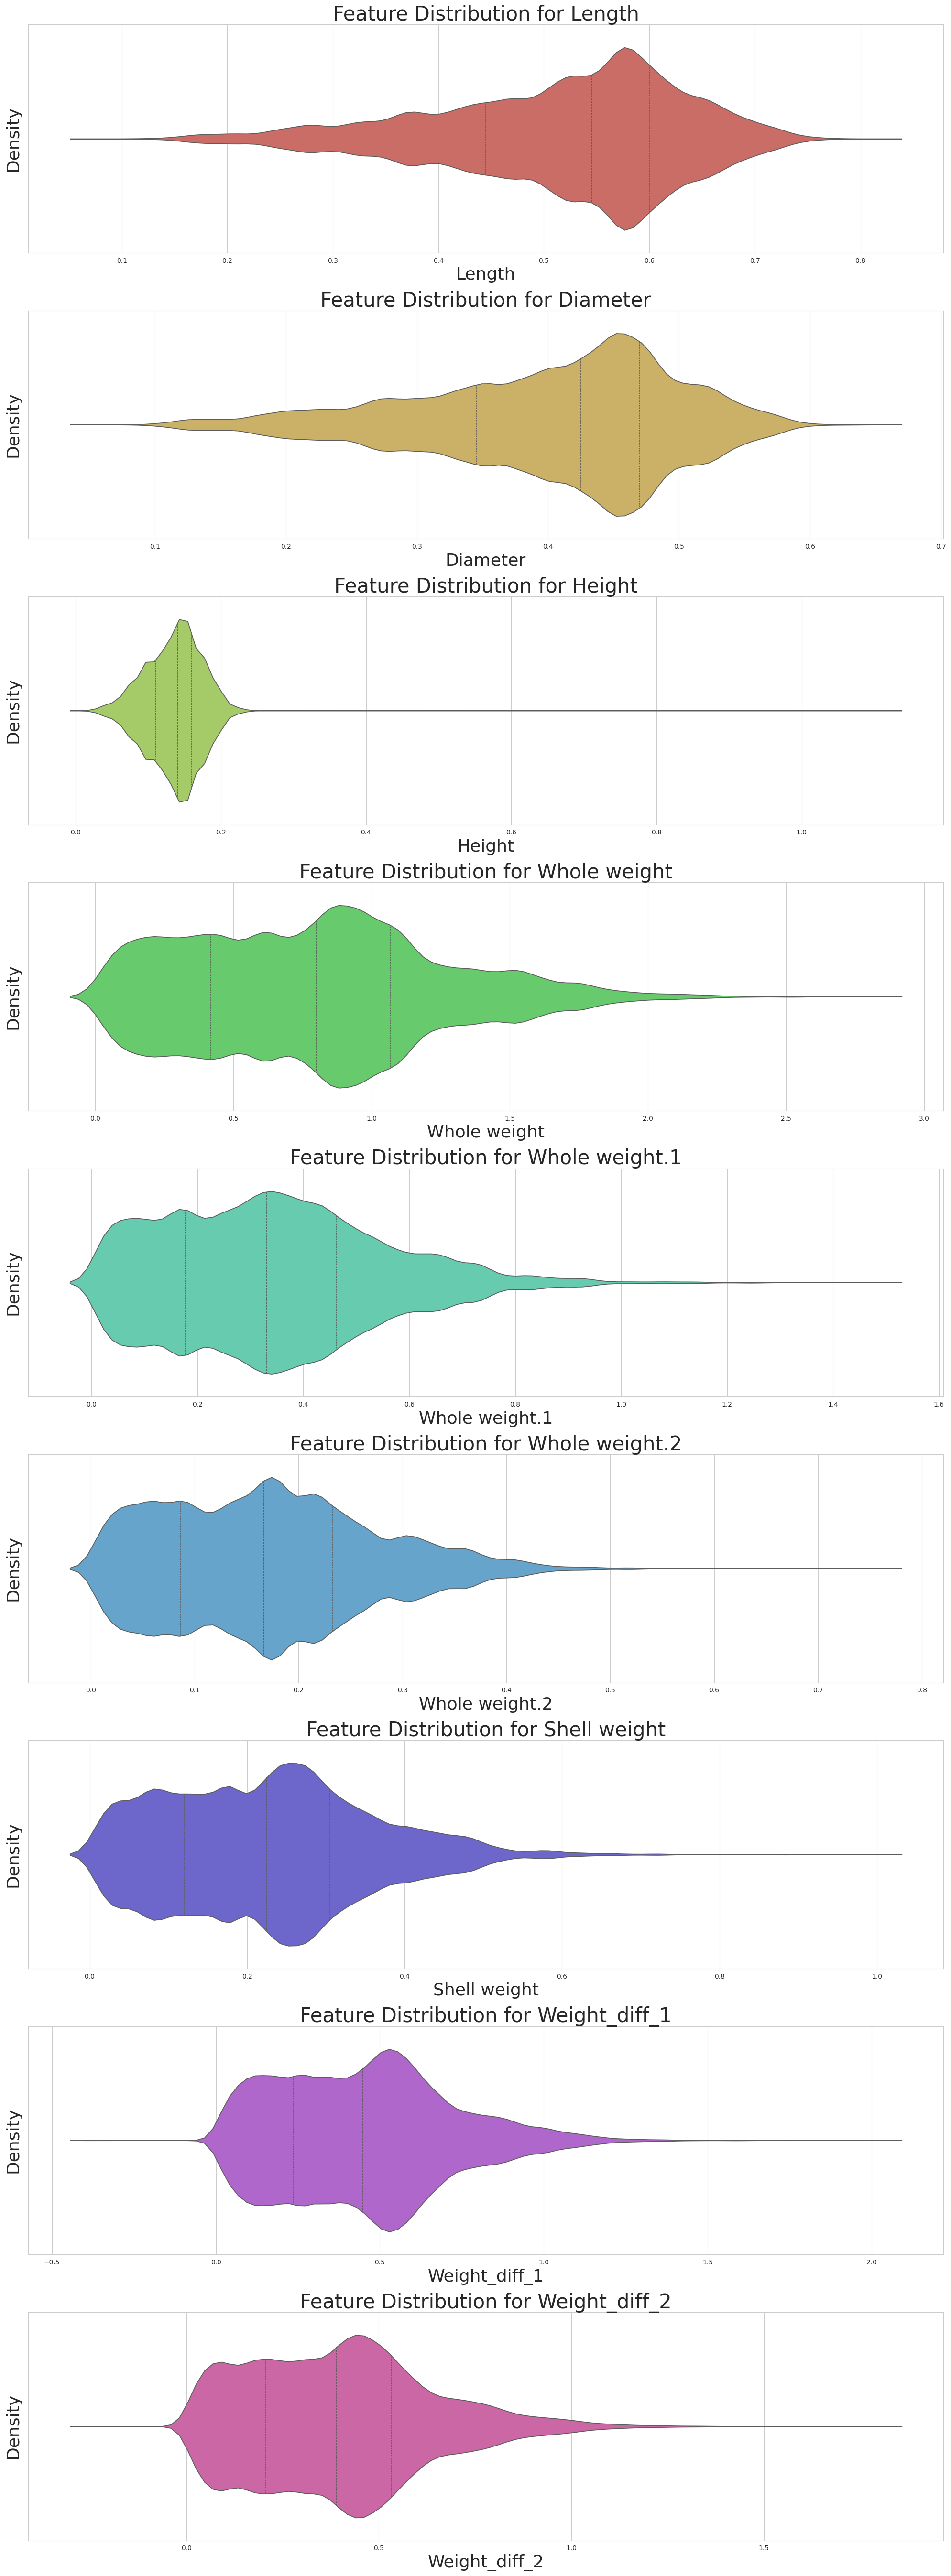

In [14]:
sns.set_style("whitegrid")
palette = sns.color_palette("hls", len(numeric_cols))
fig, axs = plt.subplots(len(numeric_cols), figsize=(20, len(numeric_cols)*6))

for i, col in enumerate(numeric_cols):
    sns.violinplot(x=train_to_scale[col], ax=axs[i], inner="quartile", palette=[palette[i]])
    axs[i].set_title('Feature Distribution for ' + col, fontsize=30)
    axs[i].set_xlabel(col, fontsize=26)
    axs[i].set_ylabel('Density', fontsize=26)
plt.tight_layout()
plt.show()

Feature distribution of Length and Diameter look same showing that the Longest shell measurement and measurement Perpendicular to length for an abalone are proportional

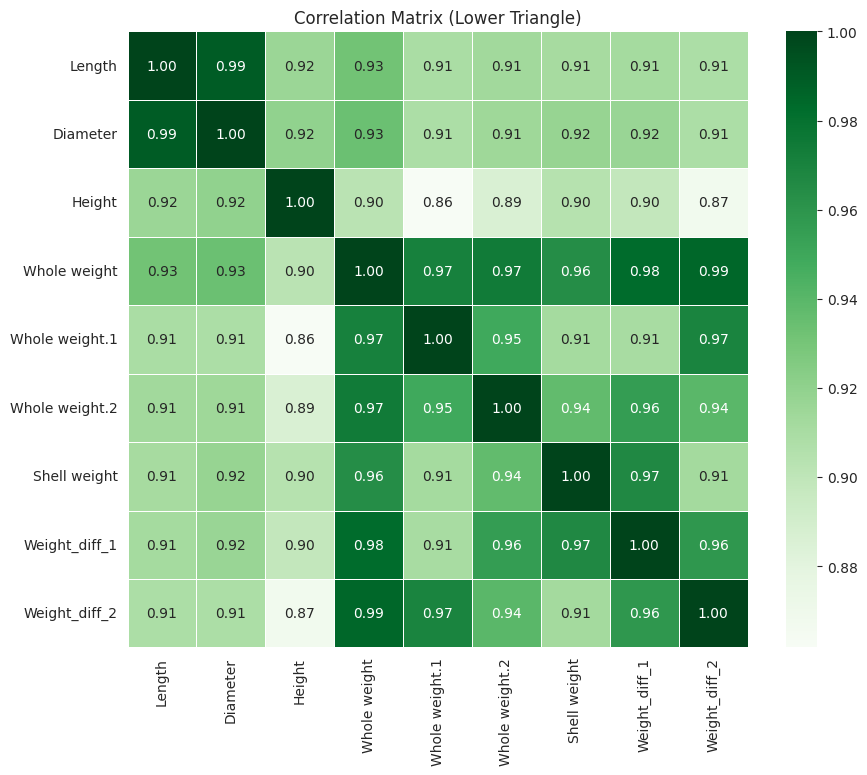

In [15]:
correlation_matrix = train_to_scale.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()

In [16]:
sc = StandardScaler()
def scale_num_cols(df) :
    scaled_df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)
    return scaled_df

scaled_train = scale_num_cols(train_to_scale)
scaled_test = scale_num_cols(test_to_scale)

In [17]:
scaled_train.head()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Weight_diff_1,Weight_diff_2
0,0.278317,0.288912,0.382451,-0.038314,-0.060061,-0.227155,0.108309,-0.019939,-0.036726
1,0.955044,0.900996,0.250897,0.745005,0.573416,1.061143,0.722736,0.848640,0.589054
2,-3.020727,-2.975535,-2.906386,-1.678148,-1.640084,-1.649238,-1.696570,-1.641412,-1.604338
3,0.658976,0.747975,0.382451,0.274140,0.169850,0.357534,0.185113,0.344182,0.275111
4,0.320613,0.237905,-0.143763,-0.015371,0.140499,-0.093370,-0.218105,-0.135623,0.129727


ONE HOT ENCODING

In [19]:
train_to_ohe = train_df[categorical_cols]
test_to_ohe = test_df[categorical_cols]
train_to_ohe.head()

,Sex
0,F
1,F
2,I
3,M
4,I
